In [2]:
import httpx as r
import pandas as pd 
import numpy as np
import time
from tqdm import tqdm
import dotenv
import os

In [ ]:
dotenv.load_dotenv(dotenv.find_dotenv())

In [3]:
STEAM_API_KEY = os.getenv('STEAM_API_KEY')

In [3]:
ROOT_URL = "https://api.steampowered.com"

GET_MATCH_HISTORY = ROOT_URL + "/IDOTA2Match_570/GetMatchHistory/v001/"
GET_MATCH_HISTORY_BY_SEQ_NUM = ROOT_URL + "/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v0001/"
GET_MATCH_DETAILS = ROOT_URL + "/IDOTA2Match_570/GetMatchDetails/v001/"
GET_LIVE_LEAGUE_GAMES = ROOT_URL + "/IDOTA2Match_570/GetLiveLeagueGames/v0001/"
GET_TEAM_INFO_BY_TEAM_ID = ROOT_URL + "/IDOTA2Match_570/GetTeamInfoByTeamID/v001/"
GET_HEROES = ROOT_URL + "/IEconDOTA2_570/GetHeroes/v0001/"
GET_GAME_ITEMS = ROOT_URL + "/IEconDOTA2_570/GetGameItems/v0001/"
GET_TOURNAMENT_PRIZE_POOL = ROOT_URL + "/IEconDOTA2_570/GetTournamentPrizePool/v1/"
GET_TOP_LIVE_GAME = ROOT_URL + "/IDOTA2Match_570/GetTopLiveGame/v1/"
GET_BROADCASTER_INFO = ROOT_URL + "/IDOTA2StreamSystem_570/GetBroadcasterInfo/v1"
GET_PLAYER_SUMMARIES = ROOT_URL + "/ISteamUser/GetPlayerSummaries/v0002/"

In [ ]:
heroes = r.get(GET_HEROES,params={'key':STEAM_API_KEY})
map_hero_names = {hero['id']:hero['name'].replace('npc_dota_hero_','') for hero in heroes.json()['result']['heroes']}

In [4]:
seq_num = 5.3e+9
# 2022-01-01 ориентировочно

In [5]:
list_of_results = []


In [160]:
# rp_seq = r.get(GET_MATCH_HISTORY_BY_SEQ_NUM,params=fetch_params)

In [402]:
sleep_time = 2
for step in tqdm(range(2000)):
    time.sleep(sleep_time)
    seq_num+=150
    fetch_params = {
                'key':STEAM_API_KEY,
                'start_at_match_seq_num':seq_num,
                }
    rp_seq = r.get(GET_MATCH_HISTORY_BY_SEQ_NUM,params=fetch_params)
    if rp_seq.status_code == 200:
        list_of_results.append(rp_seq)
    else:
        sleep_time += 0.25
        print(f'{rp_seq.status_code} : new sleep time ~ {sleep_time:.2f}')
        time.sleep(10)
        

 21%|██▏       | 429/2000 [18:55<1:09:17,  2.65s/it]


KeyboardInterrupt: 

In [486]:
import sqlite3

In [500]:
def update_base(response,test=True):

    data = pd.DataFrame(response.json()['result']['matches'])\
        .where(lambda x: x['human_players']==10)\
                .query('lobby_type in (0,7) and game_mode in (23,22,19)')\
                    .dropna(axis=1)

    general_table = data.drop(['players'],axis=1).set_index('match_id')
            
    match_table = pd.json_normalize(data['players'].explode('players')).dropna(axis=1)
    match_table[['radiant_win','match_id']] = data.explode('players')[['radiant_win','match_id']].values
    match_table = match_table.set_index('match_id')
    if test:
        return general_table,match_table
    with sqlite3.connect('dota2base.db') as connect:
        match_table.to_sql('match_table',if_exists='append',con=connect)
        general_table.to_sql('general_stats_table',if_exists='append',con=connect)


In [502]:
for resp in  tqdm(list_of_results):
    update_base(resp)

100%|██████████| 2030/2030 [02:23<00:00, 14.10it/s]


In [8]:
concated_data = pd.concat([pd.DataFrame(step.json()['result']['matches']) for step in list_of_results])

In [40]:
concated_data.describe()['start_time'].astype('datetime64[s]')

count   1970-01-01 08:13:20
mean    2021-12-25 20:33:57
std     1970-01-01 00:18:54
min     2021-12-25 13:54:10
25%     2021-12-25 20:21:27
50%     2021-12-25 20:33:46
75%     2021-12-25 20:46:07
max     2021-12-25 21:29:22
Name: start_time, dtype: datetime64[ns]

In [41]:
df = concated_data

In [43]:
def get_hero_matrix(row,agg='mean'):
     return pd.DataFrame(row['players'])\
        .groupby('team_number')['hero_id'].apply(list).to_frame().T\
            .explode(column=[0,1])\
                .assign(win=row['radiant_win'])\
                    .pivot_table('win',0,1,aggfunc=agg)

In [44]:
matrics_pct = [get_hero_matrix(row,'mean') for idx,row in tqdm(df.iterrows())]

20457it [03:14, 105.20it/s]
20457it [03:09, 107.70it/s]


In [74]:
hero_matrix = pd.concat(matrics_pct).groupby(level=0).mean()

In [282]:
hero_matrix.rename(index=map_hero_names,columns=map_hero_names).loc[:,['slardar','visage','viper','troll_warlord','shredder']].where(lambda x:( x!=0 )& (x!=1)).mean(axis=1).sort_values(ascending=False).iloc[:20]

0
enigma                 0.750000
luna                   0.702525
phantom_lancer         0.690476
puck                   0.685185
chen                   0.666667
dark_seer              0.666667
meepo                  0.666667
keeper_of_the_light    0.666667
kunkka                 0.666667
dragon_knight          0.665278
silencer               0.662121
centaur                0.655556
grimstroke             0.645833
abyssal_underlord      0.645833
legion_commander       0.645238
ogre_magi              0.641795
antimage               0.640606
vengefulspirit         0.633333
tiny                   0.625000
pudge                  0.616936
dtype: float64

In [107]:
matrics_play = [get_hero_matrix(row,'count') for idx,row in tqdm(df.iterrows())]
matrics_win = [get_hero_matrix(row,'sum') for idx,row in tqdm(df.iterrows())]

20457it [03:10, 107.50it/s]
20457it [03:15, 104.77it/s]


In [109]:
hero_wins = pd.concat(matrics_win).groupby(level=0).sum()
hero_matches = pd.concat(matrics_play).groupby(level=0).sum()

In [114]:
import scipy.stats as sps

In [122]:
import matplotlib.pyplot as plt

In [159]:
global_wr = sps.beta(hero_wins.sum().sum(),hero_matches.sum().sum() - hero_wins.sum().sum())
am_wr = sps.beta(hero_wins.loc[1].sum(),hero_matches.loc[1].sum() - hero_wins.loc[1].sum())

In [220]:
def wr_distribution(hero_id,enemy_id):
    return sps.beta(hero_wins.loc[hero_id,enemy_id]+1,hero_matches.loc[hero_id,enemy_id]+1 - hero_wins.loc[hero_id,enemy_id])

In [283]:
from dataclasses import dataclass

In [395]:
@dataclass
class Hero:
    wins:list
    matches:list

    def __post_init__(self):
        self.value_space = np.array([np.linspace(.5,.99)]*self.wins.shape[0]).T
        self.defeats = self.matches - self.wins
        self.hero_ids = self.wins.index
        self.hero_names = [map_hero_names[i] for i in self.hero_ids]
        self.hero_name = map_hero_names[self.wins.name]
    def get_scores(self):
        hero_distr = sps.beta(self.wins+1,self.defeats+1)
        log_like = np.log1p(hero_distr.sf(self.value_space)).sum(axis=0) / hero_distr.std()
        return pd.Series(log_like,self.hero_names).rename(self.hero_name)
    def plot_top(self,n=10):
        scores = self.get_scores().sort_values()

        data = pd.concat([
                        scores.iloc[:10],
                        scores.iloc[-10:],
        ]
        ).rename('win log like').to_frame().apply(lambda x: (x-x.mean()) / (x.max()-x.min()))
        return data.plot.bar(title=self.hero_name)

In [400]:
antimage = Hero(wins=hero_wins.loc[22],
                    matches=hero_matches.loc[22])

<AxesSubplot:title={'center':'zuus'}>

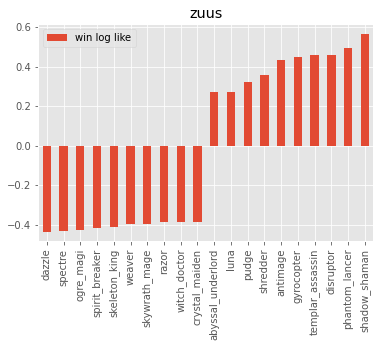

In [401]:
antimage.plot_top()

In [224]:
plt.style.use('ggplot')

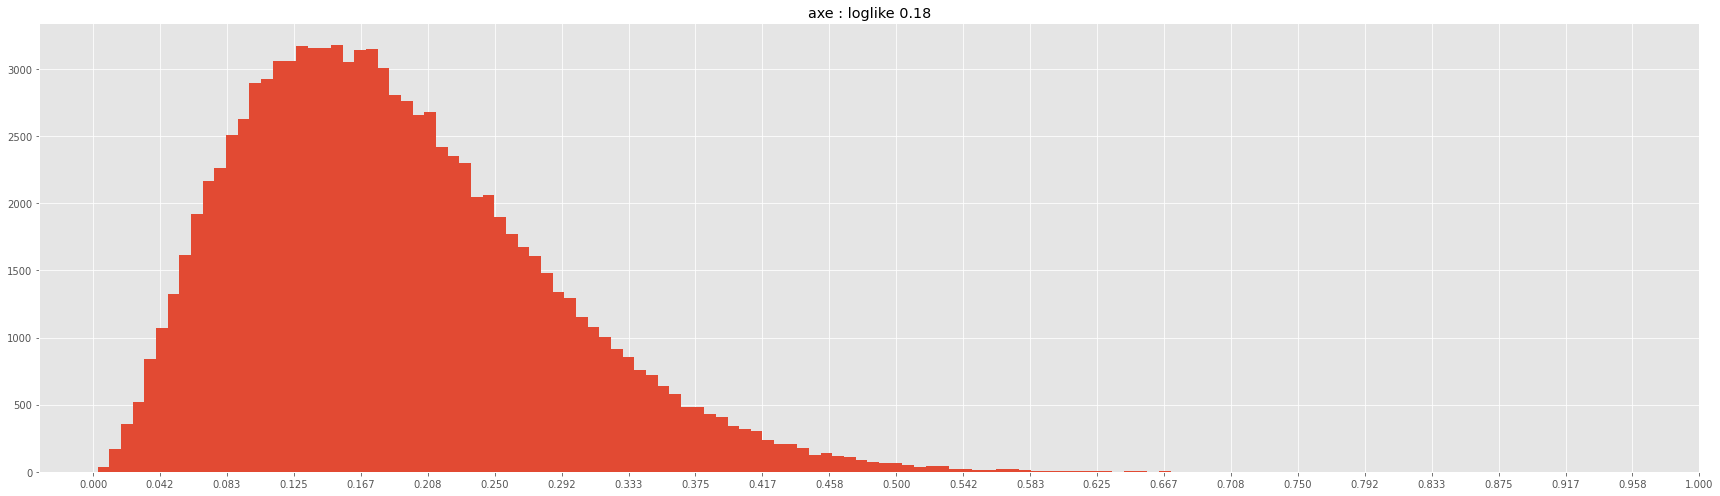

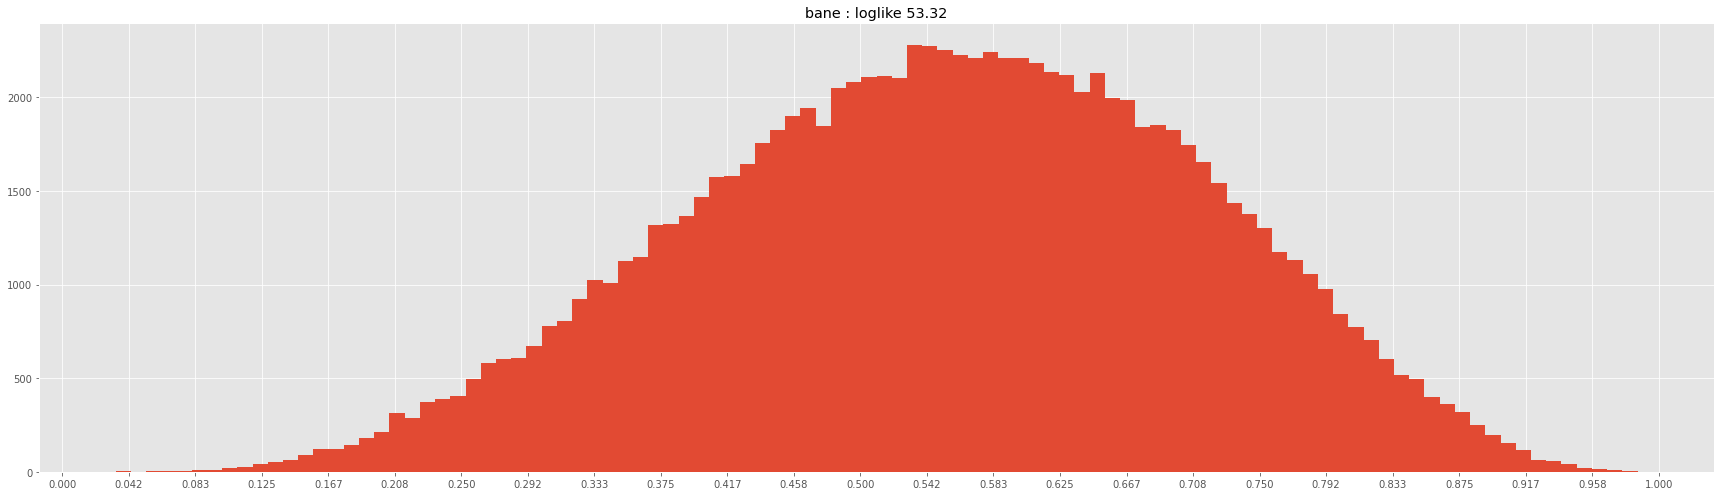

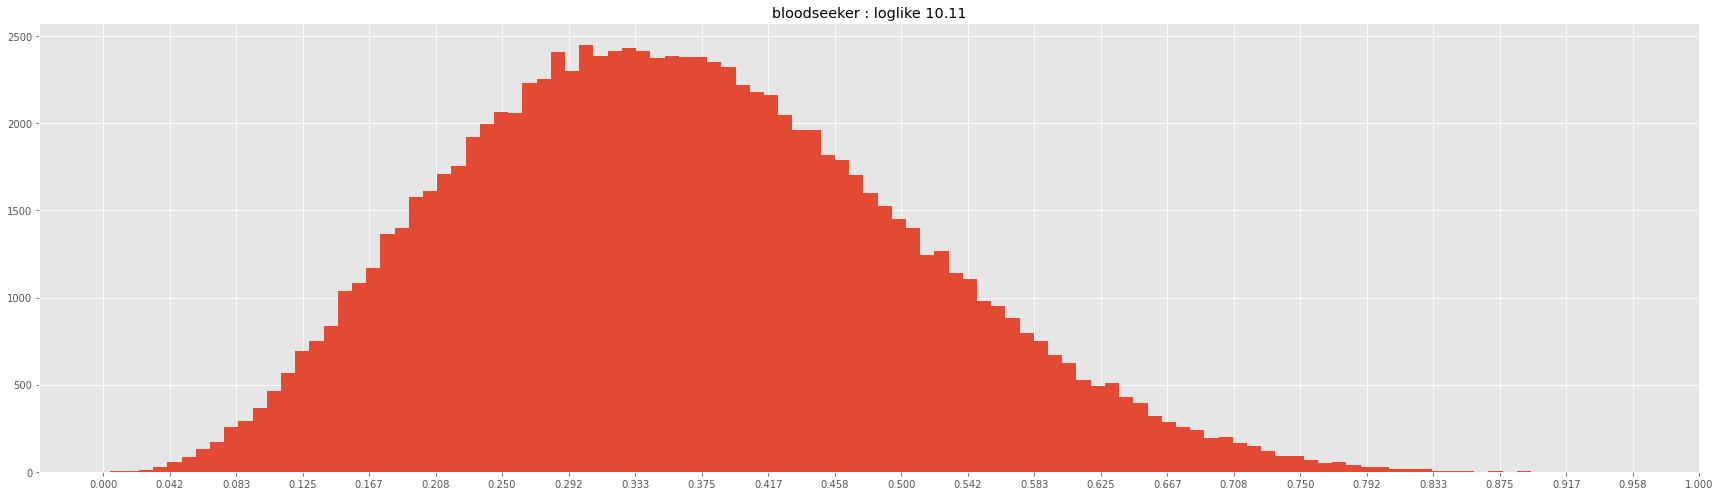

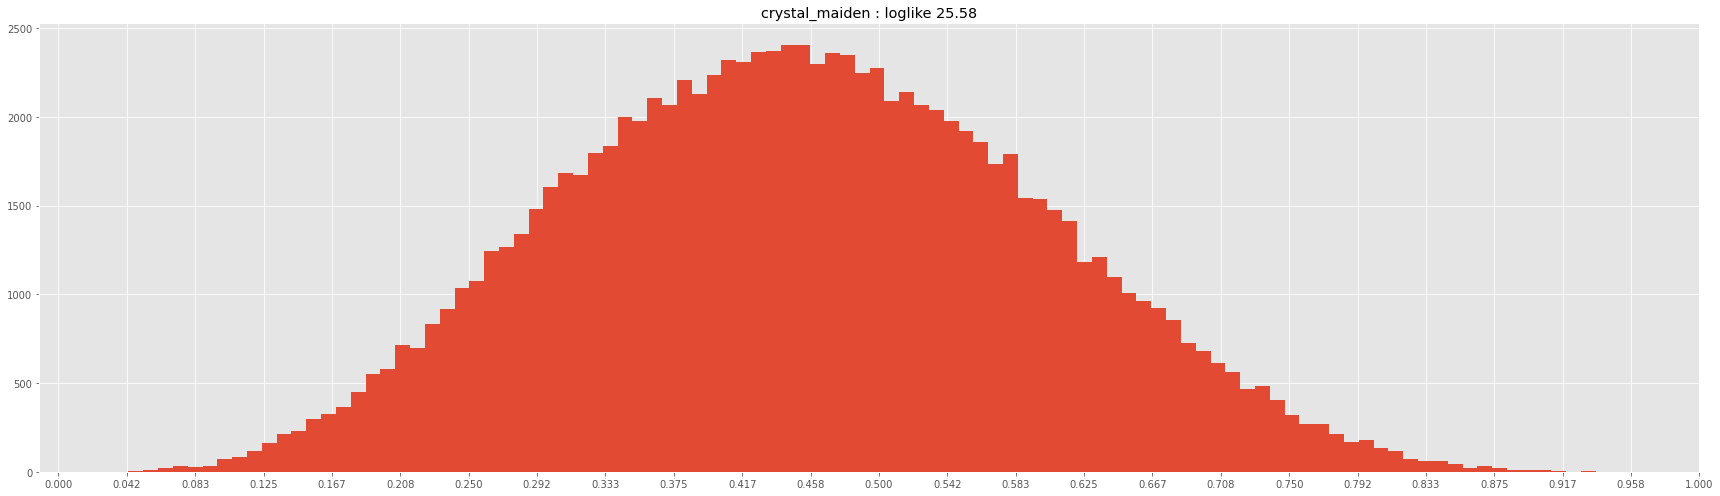

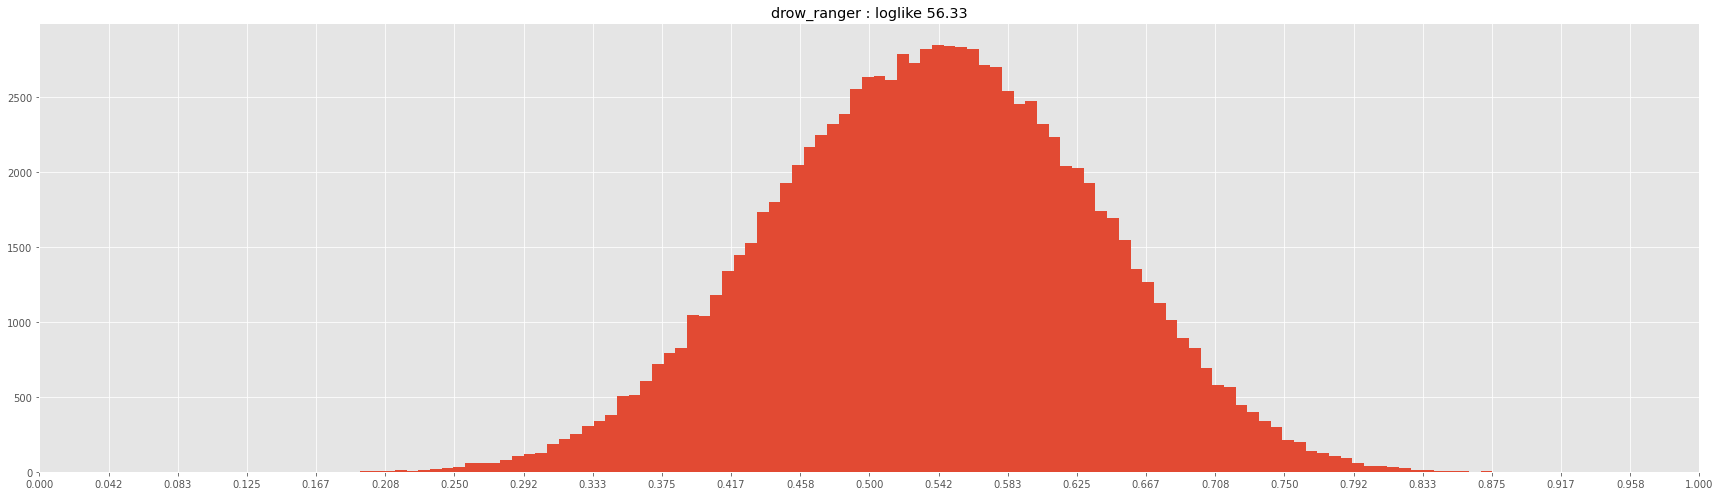

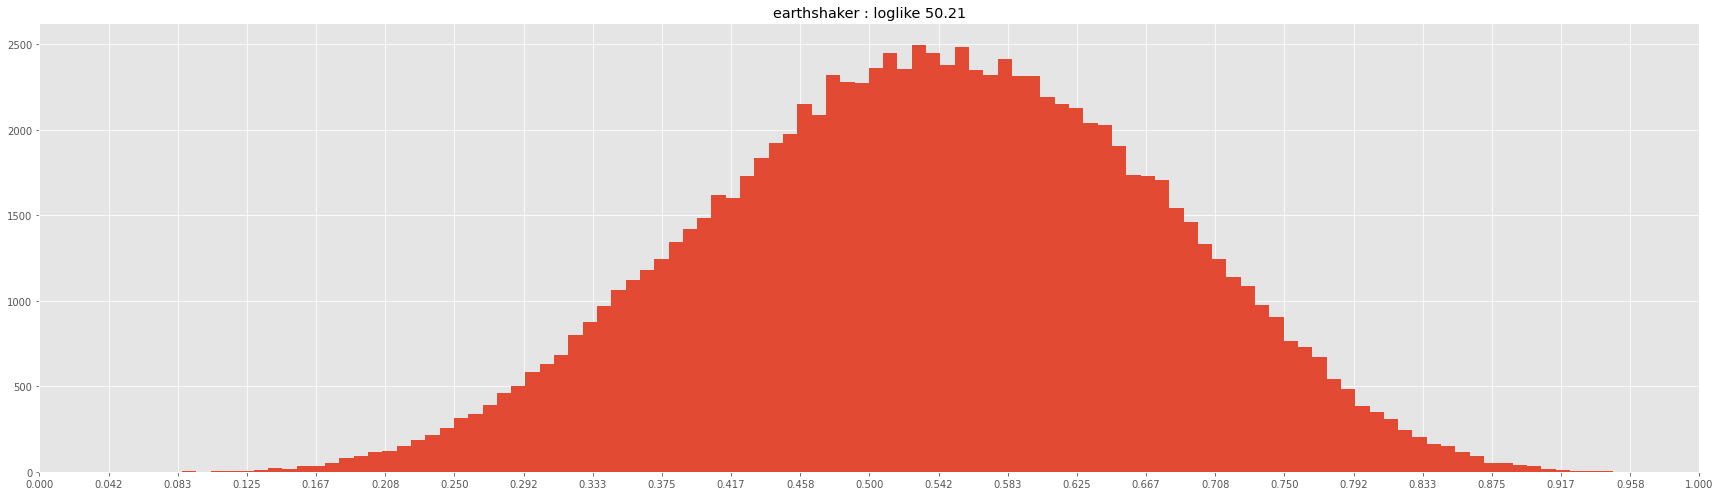

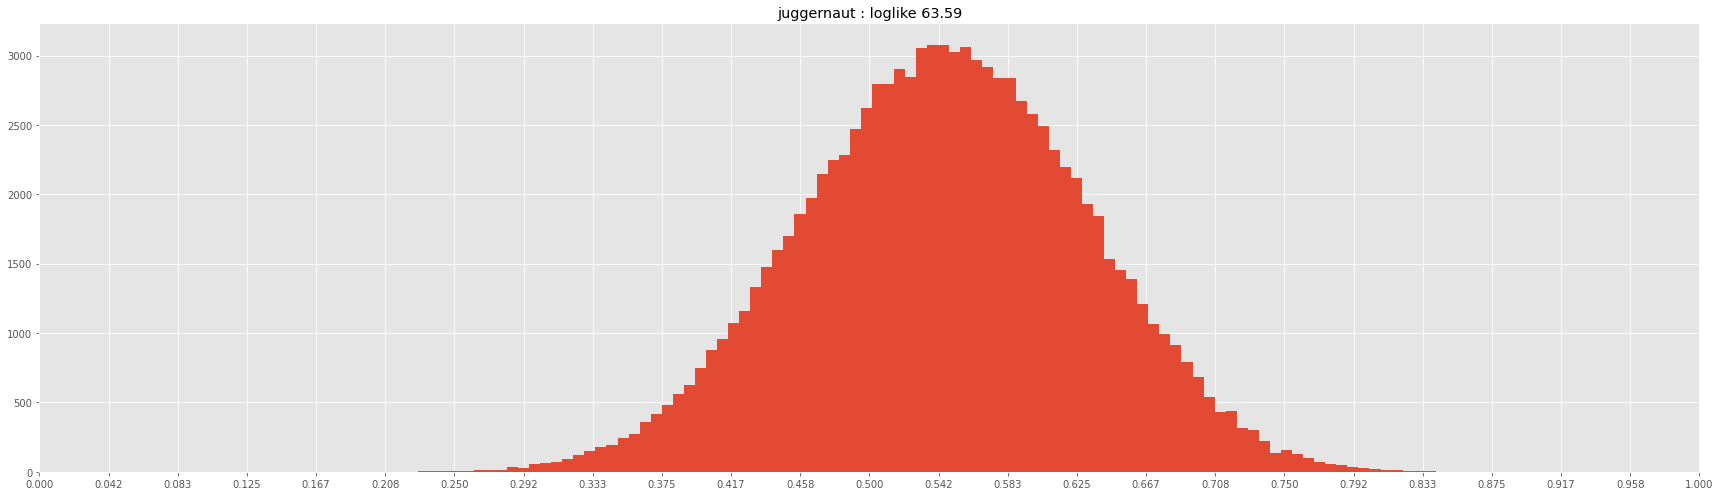

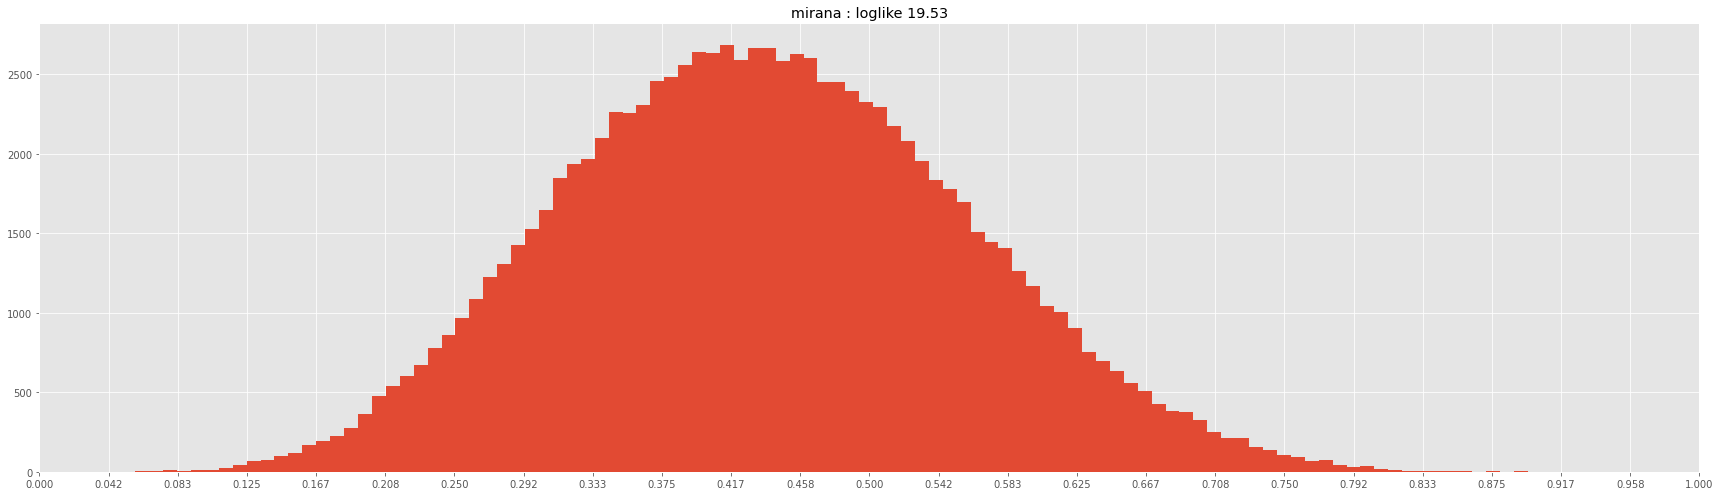

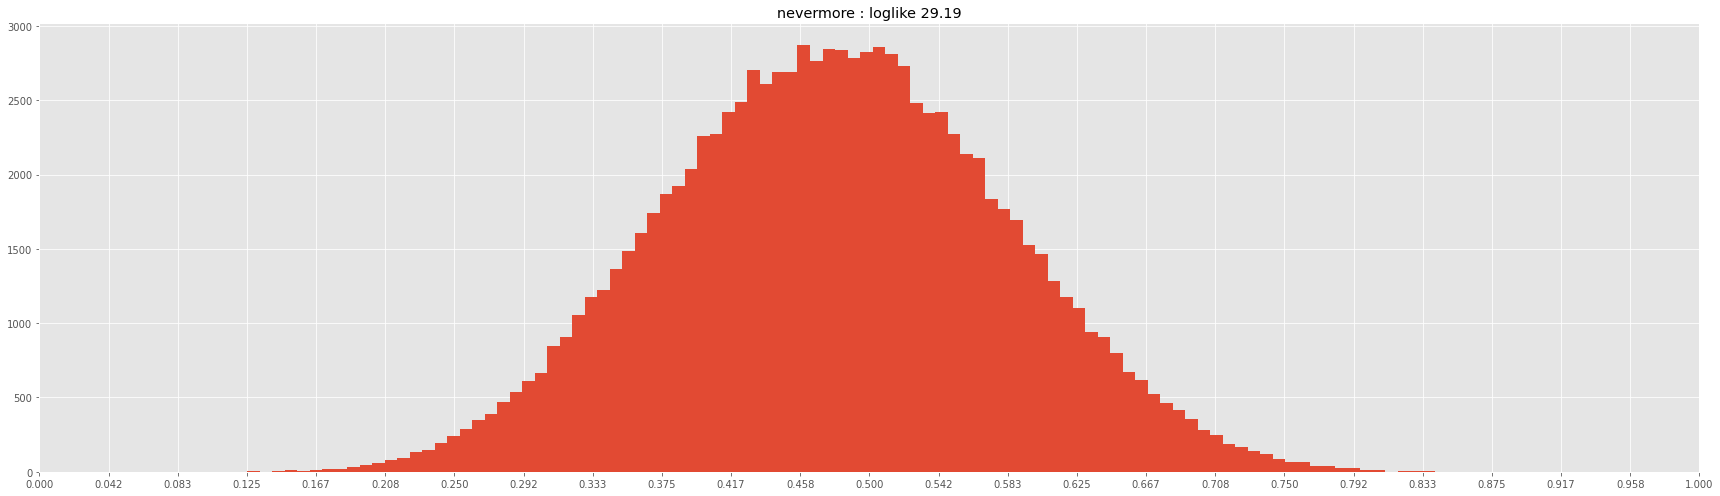

In [260]:
for hero in list(map_hero_names.keys())[1:10]:
    fig,ax = plt.subplots(figsize=(24,7))
    hero_dist = wr_distribution(1,hero)
    ax.hist(hero_dist.rvs(100000),bins=100);
    ax.set_xticks(np.linspace(0,1,25))
    ax.set_title(f'{map_hero_names[hero]} : loglike {np.log1p(hero_dist.sf(np.linspace(0.5,.99))).sum() / hero_dist.std() :.2f}')
    plt.tight_layout()

In [140]:
game_modes = {
  "0": {
    "id": 0,
    "name": "game_mode_unknown",
    "balanced": True
  },
  "1": {
    "id": 1,
    "name": "game_mode_all_pick",
    "balanced": True
  },
  "2": {
    "id": 2,
    "name": "game_mode_captains_mode",
    "balanced": True
  },
  "3": {
    "id": 3,
    "name": "game_mode_random_draft",
    "balanced": True
  },
  "4": {
    "id": 4,
    "name": "game_mode_single_draft",
    "balanced": True
  },
  "5": {
    "id": 5,
    "name": "game_mode_all_random",
    "balanced": True
  },
  "6": {
    "id": 6,
    "name": "game_mode_intro"
  },
  "7": {
    "id": 7,
    "name": "game_mode_diretide"
  },
  "8": {
    "id": 8,
    "name": "game_mode_reverse_captains_mode"
  },
  "9": {
    "id": 9,
    "name": "game_mode_greeviling"
  },
  "10": {
    "id": 10,
    "name": "game_mode_tutorial"
  },
  "11": {
    "id": 11,
    "name": "game_mode_mid_only"
  },
  "12": {
    "id": 12,
    "name": "game_mode_least_played",
    "balanced": True
  },
  "13": {
    "id": 13,
    "name": "game_mode_limited_heroes"
  },
  "14": {
    "id": 14,
    "name": "game_mode_compendium_matchmaking"
  },
  "15": {
    "id": 15,
    "name": "game_mode_custom"
  },
  "16": {
    "id": 16,
    "name": "game_mode_captains_draft",
    "balanced": True
  },
  "17": {
    "id": 17,
    "name": "game_mode_balanced_draft",
    "balanced": True
  },
  "18": {
    "id": 18,
    "name": "game_mode_ability_draft"
  },
  "19": {
    "id": 19,
    "name": "game_mode_event"
  },
  "20": {
    "id": 20,
    "name": "game_mode_all_random_death_match"
  },
  "21": {
    "id": 21,
    "name": "game_mode_1v1_mid"
  },
  "22": {
    "id": 22,
    "name": "game_mode_all_draft",
    "balanced": True
  },
  "23": {
    "id": 23,
    "name": "game_mode_turbo"
  },
  "24": {
    "id": 24,
    "name": "game_mode_mutation"
  }
}

In [201]:
game_lobby = {
  "0": {
    "id": 0,
    "name": "lobby_type_normal",
    "balanced": True
  },
  "1": {
    "id": 1,
    "name": "lobby_type_practice",
    "balanced": True
  },
  "2": {
    "id": 2,
    "name": "lobby_type_tournament",
    "balanced": True
  },
  "3": {
    "id": 3,
    "name": "lobby_type_tutorial"
  },
  "4": {
    "id": 4,
    "name": "lobby_type_coop_bots"
  },
  "5": {
    "id": 5,
    "name": "lobby_type_ranked_team_mm",
    "balanced": True
  },
  "6": {
    "id": 6,
    "name": "lobby_type_ranked_solo_mm",
    "balanced": True
  },
  "7": {
    "id": 7,
    "name": "lobby_type_ranked",
    "balanced": True
  },
  "8": {
    "id": 8,
    "name": "lobby_type_1v1_mid"
  },
  "9": {
    "id": 9,
    "name": "lobby_type_battle_cup",
    "balanced": True
  }
}